In [1]:
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, LocallyConnected2D, Conv2D, MaxPooling2D, UpSampling2D, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import Add, AveragePooling2D
from keras.regularizers import l1
from keras.layers import deserialize as layer_from_config
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os.path
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model
import h5py

from PIL import Image
import numpy as np
import fnmatch

/Users/mateuszochal/.virtualenvs/COMP6208venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
img_width, img_height = 256, 192

train_data_dir = 'test'
validation_data_dir = 'val/'
nb_train_samples = 8000
nb_validation_samples = 400
nb_epoch = 5
batch = 8
augment_batch = 1

In [56]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        class_mode='input',
        batch_size=batch,
        target_size=(img_width, img_height),
        classes=None)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        class_mode='input',
        batch_size=batch,
        target_size=(img_width, img_height),
        classes=None)

Found 125436 images belonging to 1 classes.
Found 41620 images belonging to 1 classes.


In [57]:
def dense_cnn_combined_autoencoder_oid(input_image_dim, output_image_dim, epochs=15,
                            retrain=False, model_filename="dense_cnn_combined_autoencoder_oid.h5"):
    if os.path.isfile(model_filename) and not retrain:
        upscaler = load_model(model_filename)
        upscaler.summary()
    else:
        print(input_image_dim, output_image_dim)
        
        input_model = Input(shape=output_image_dim)
        
#         dense = Flatten()(input_model)
#         dense = Dense(40*40*3, activation='relu', activity_regularizer=l1(1e-5))(dense)
#         dense = Dense(256*192*3, activation='relu', activity_regularizer=l1(1e-5))(dense)
#         dense = Reshape(target_shape = output_image_dim)(dense)
        
        cnn = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_image_dim)(input_model)
        cnn = Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_image_dim)(cnn)
        cnn = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_image_dim)(cnn)
        cnn = AveragePooling2D(pool_size=2)(cnn)
        cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn)
        cnn = UpSampling2D((2, 2))(cnn)
        cnn = Conv2D(3, (3, 3), activation='relu', padding='same')(cnn)
        cnn = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(cnn)
        
        
#         added = Add()([dense, cnn])
        upscaler = Model(inputs=[input_model], outputs=cnn)
        upscaler.compile(optimizer='adam', loss='mean_squared_error')
        upscaler.summary()
        
    return upscaler

model = dense_cnn_combined_autoencoder_oid(
    (img_width, img_height, 3), (img_width, img_height, 3)
)

(256, 192, 3) (256, 192, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 192, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 192, 32)      896       
_________________________________________________________________
average_pooling2d_3 (Average (None, 128, 96, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 96, 32)       9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 256, 192, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 192, 3)       867       
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
____________________________________________

In [58]:
# model.fit(x_train, y_train,
#              epochs=epochs,
#              shuffle=True,
#              validation_data=(x_test, y_test))
# steps_per_epoch = 

model.fit_generator(
        train_generator,
        steps_per_epoch = 100,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
#         batch_size=batch,
#         shuffle=True,
#         validation_data = validation_generator,
#         nb_val_samples = nb_validation_samples)
)

/Users/mateuszochal/.virtualenvs/COMP6208venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/Users/mateuszochal/.virtualenvs/COMP6208venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=1000, epochs=5)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/5
  35/1000 [>.............................] - ETA: 15:20 - loss: 0.0979

KeyboardInterrupt: 

In [51]:
x_batch, y_batch = validation_generator.next()
predict = model.predict(x_batch)

In [52]:
np.shape(predict)

(8, 256, 192, 3)

In [28]:
def draw_images(images, n=12):
    """
    params:
    > n: how many digits we will display
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='Greys')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def draw_images_generator(images_generator, n=12):
    """
    params:
    > n: how many digits we will display
    """
    plt.figure(figsize=(20, 4))
    x_batch, y_batch = images_generator.next()
    print(np.shape(batch))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(x_batch[i], cmap='Greys')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

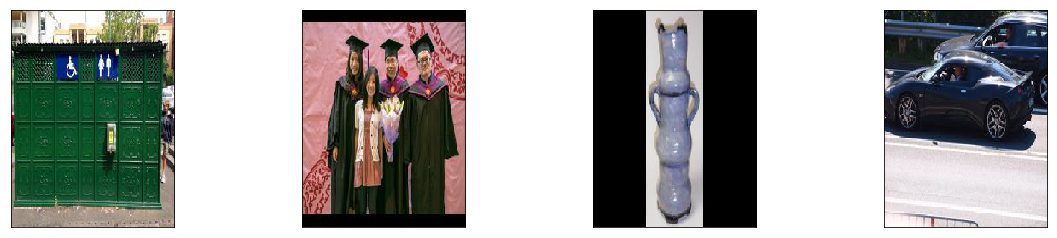

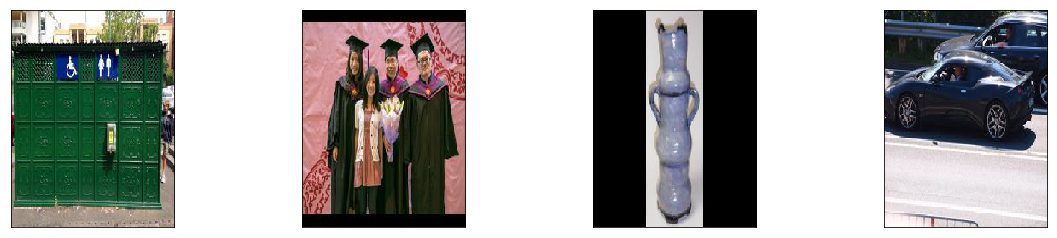

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


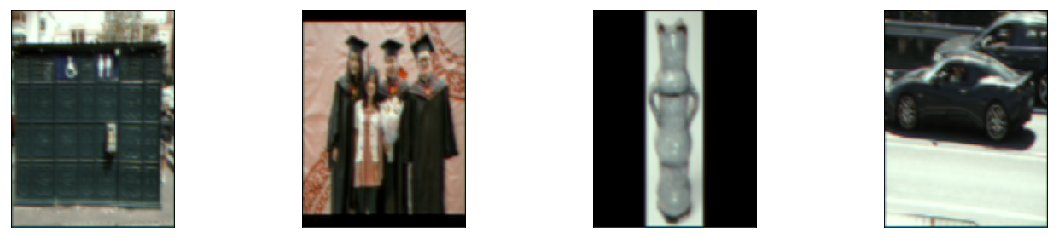

In [53]:
draw_images(x_batch, n=4)
draw_images(y_batch, n=4)
draw_images(predict, n=4)

In [20]:

# input image dimensions
img_rows, img_cols, img_chns = 256, 256, 1
batch_size = 8

train_datagen = ImageDataGenerator(data_format='channels_first',
                                   rescale=1./255)

test_datagen = ImageDataGenerator(data_format='channels_first',
                                  rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'test', 
        color_mode='grayscale',
        class_mode='input',
        target_size=(img_rows, img_cols),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
        'val',
        color_mode='grayscale',
        class_mode='input',
        target_size=(img_rows, img_cols),
        batch_size=batch_size)

Found 125436 images belonging to 1 classes.
Found 41620 images belonging to 1 classes.


In [36]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

K.set_image_data_format('channels_first')
K.set_image_dim_ordering('th')

print("Image data format: ", K.image_data_format())
print("Image dimension ordering: ", K.image_dim_ordering())
print("Backend: ", K.backend())


# number of convolutional filters to use
filters = 16

# convolution kernel size
num_conv = 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
    
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 5

print("Original image size: ", original_img_size)
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * intermediate_dim * intermediate_dim, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, intermediate_dim, intermediate_dim)
else:
    output_shape = (batch_size, intermediate_dim, intermediate_dim, filters)

print('Output shape 1: ', output_shape)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_chns, img_rows)
else:
    output_shape = (batch_size, img_chns, img_rows, filters)
    
print('Output shape 2: ', output_shape)

decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='same',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
def my_vae_loss(y_true, y_pred):
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=my_vae_loss)

vae.summary()

#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
#x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

#print('x_train.shape:', x_train.shape)

vae.fit_generator(train_generator,
        steps_per_epoch=100 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=10 // batch_size)

Image data format:  channels_first
Image dimension ordering:  th
Backend:  tensorflow
Original image size:  (1, 256, 256)
Output shape 1:  (8, 16, 128, 128)
Output shape 2:  (8, 16, 1, 256)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 1, 256, 256)  5           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 16, 128, 128) 80          conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)

KeyboardInterrupt: 

In [ ]:
x_batch, y_batch = train_generator.next()
predict = vae.predict(x_batch)

In [ ]:
print(np.shape(x_batch))
print(np.shape(y_batch))
print(np.shape(predict))


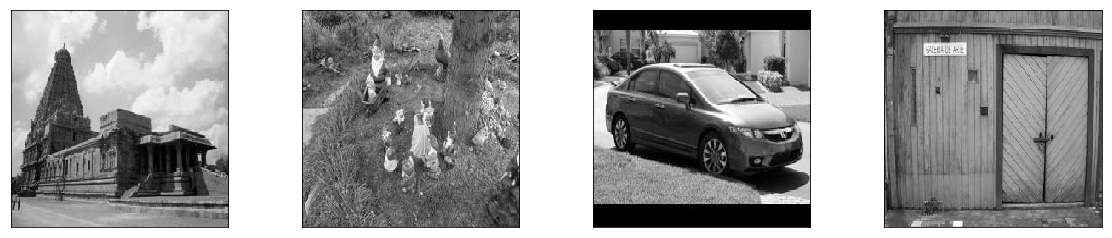

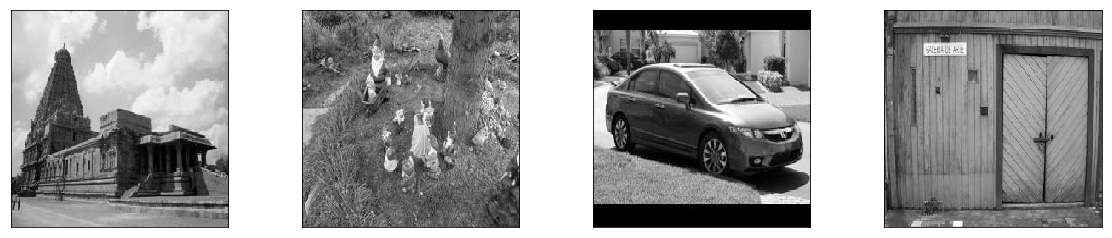

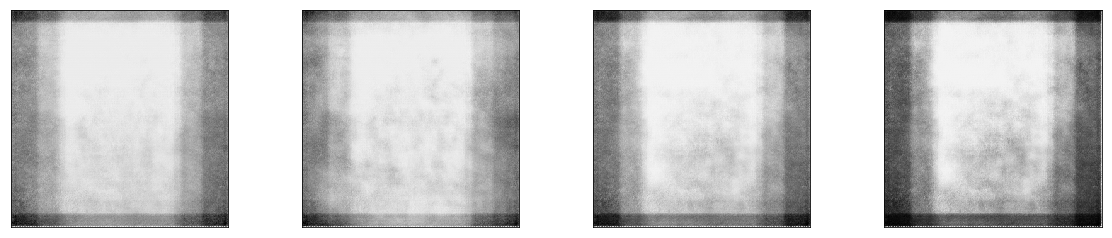

In [35]:
def draw_images(images, n=12):
    """
    params:
    > n: how many digits we will display
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap='Greys')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

draw_images(x_batch, n=4)
draw_images(y_batch, n=4)
draw_images(predict, n=4)